In [1]:
import random
import math
import numpy as np

from math import sin, cos, acos

import copy


import sys, os, time

from qinfer import LiuWestResampler
from qinfer import utils

from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, Aer

import qiskit.ignis.verification.randomized_benchmarking as rb

IBMQ.load_account()

Failed to import duecredit due to No module named 'duecredit'
/home/alan/aur/miniconda3/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "
/home/alan/aur/miniconda3/lib/python3.8/site-packages/qinfer/parallel.py:61: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbs

import smc_unitary as smc
Distribution = smc.Distribution

sbs.set(style="darkgrid")

%matplotlib inline

In [3]:
def random_circuit(n_qubits):
    length_vector = [1]
    n_seeds = 1
    
    initial_list = list(range(0, n_qubits))    
    rb_pattern = []
    
    while len(initial_list) > 1:
        sample = random.sample(initial_list, 2)
        [initial_list.remove(i) for i in sample]
        rb_pattern.append(sample)
    
    if len(initial_list) == 1:
        rb_pattern.append([initial_list[0]])
    
    
    circuit, xdata = rb.randomized_benchmarking_seq(
        length_vector = [1],
        nseeds = 1,
        rb_pattern = rb_pattern
        )
    circuit = circuit[0][0]
    cregs = circuit.cregs
    
    circuit.remove_final_measurements(inplace=True)
    circuit.cregs = cregs
    
    for i in range(n_qubits):
        circuit.barrier(i)
        if (round(random.random())):
            circuit.x(i)
            circuit.barrier(i)
    
    return circuit

In [4]:
# Only one qubit for now
def design_circuit(n_qubits, unitary_arr, circuit=None):
    
    if circuit is None:
        circuit = QuantumCircuit(n_qubits, n_qubits)
    
    if unitary_arr is not None:
        circuit.rx(unitary_arr[0], 0)
        circuit.rz(unitary_arr[1], 0)
    
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))
    return circuit

In [5]:
circuit = random_circuit(1)
circuit.draw()

┌───┐┌─────┐┌───┐┌───┐ ░ ┌───┐┌───┐┌───┐┌───┐ ░ 
qr_0: ┤ H ├┤ SDG ├┤ H ├┤ Z ├─░─┤ Z ├┤ H ├┤ S ├┤ H ├─░─
      └───┘└─────┘└───┘└───┘ ░ └───┘└───┘└───┘└───┘ ░ 
cr_0: ════════════════════════════════════════════════

In [7]:
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_vigo')


n_qubits = 1
n_circuits_sampled = 200

results = []


for __ in range(n_circuits_sampled):
    
    
    circuit = random_circuit(n_qubits)
    result_data = {}
    result_data['risk'] = []
    result_data['mean'] = []
    result_data['counts'] = []
    result_data['circuit'] = circuit

    dist = Distribution(n_points=4000, n_qubits=1)
    for _ in range(30):

        u2_gates = dist.next_experiment()       

        print(u2_gates)

        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, u2_gates, circuit=tmp_circuit)

        job = execute(tmp_circuit, backend, shots=1)

        result = job.result()
        outcome = list(map(int, list(list(result.get_counts(tmp_circuit).keys())[0])))     

        best_estimate = dist.calc_best_experiment()
        
        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, best_estimate, circuit=tmp_circuit)

        job = execute(tmp_circuit, backend, shots=4096)
        result = job.result()
        outcome_full = result.get_counts(tmp_circuit)

        dist.measure(outcome, u2_gates)

        result_data['risk'].append(dist.calc_bayes_risk())
        result_data['mean'].append(dist.calc_bayes_mean())
        result_data['counts'].append(outcome_full)

        print(result_data['risk'][-1], result_data['mean'][-1])

    result_data['distrubtion'] = dist
    results.append(result_data)

[6.28195967 0.97028171]
6.93665370342968 [-2.66397590e-04  3.68628739e-18]
[0.01485974 4.42315457]
6.1857933791933055 [-1.84594468e-02 -1.08516144e-16]
[1.03299115e-03 2.39040732e+00]
6.250053605650249 [-2.19811200e-02 -1.19814187e-16]
[6.28254098 6.14321806]
6.317557812497667 [-2.62212991e-02 -1.00499824e-16]
[0.02398943 1.82164053]
6.386381370757507 [-2.42287103e-02 -9.66752584e-17]
[0.01070102 2.63440213]
6.454003571564355 [-2.55701626e-02 -9.88546742e-17]
[0.08774454 5.04108544]
6.518889699002533 [-5.76494036e-03 -1.23845322e-16]
[6.27467559 1.69805994]
6.580550744824178 [-1.20897064e-02 -1.33068029e-16]
[0.01382158 3.8217397 ]
6.282222553351594 [-1.09306911e-02 -9.83868992e-17]
[0.01255403 5.41390705]
6.329867650415871 [-1.13153720e-02 -9.65825062e-17]
[0.01616482 3.45090249]
6.163545931971126 [-1.34351092e-02 -6.35732704e-17]
[0.01798458 3.47441965]
6.065584029071673 [-1.57893205e-02 -1.09213688e-16]
[0.02367065 0.25206727]
6.00477680740397 [-2.00188766e-02 -1.29764314e-16]
[0.04

KeyboardInterrupt: 

In [10]:
len(result_data['mean'])

21

In [52]:
circuit_init = copy.deepcopy(circuit)
circuit_init = design_circuit(n_qubits, None, circuit=circuit_final)

u2_gates = dist.calc_bayes_mean()
circuit_final = copy.deepcopy(circuit)
circuit_final = design_circuit(n_qubits, u2_gates, circuit=circuit_final)

NameError: name 'circuit_final' is not defined

In [29]:
circuit_final.draw()

┌───┐┌───┐ ░ ┌───┐┌───┐ ░ ┌───────────────────┐┌─┐
qr_0: ┤ H ├┤ Z ├─░─┤ Z ├┤ H ├─░─┤ U2(2.0451,3.0712) ├┤M├
      └───┘└───┘ ░ └───┘└───┘ ░ └───────────────────┘└╥┘
cr_0: ════════════════════════════════════════════════╩═

In [51]:
circuit_final.draw()

NameError: name 'circuit_final' is not defined

In [53]:
dist.calc_bayes_mean()

array([2.12536867, 3.03783898])

In [19]:
result_data['mean'][20]

array([3.02588609, 3.07325365])

In [26]:
result_data['mean'][25]

array([2.80636943, 3.0039463 ])

In [24]:
max(zip(dist.weights, dist.points))

(0.0007077183913845979, array([4.86118716, 4.78508858]))

In [38]:
plt.plot([1 - (max(results[2]['counts'][i]['1'], results[2]['counts'][i]['0']) / 4096) for i in range(30)])

Task exception was never retrieved
future: <Task finished name='Task-533' coro=<WebsocketClient.get_job_status() done, defined at /home/alan/aur/miniconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/websocket.py:208> exception=WebsocketError('Failed to connect to the server.')>
Traceback (most recent call last):
  File "/home/alan/aur/miniconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/websocket.py", line 167, in _connect
    websocket = yield from connect(url)
  File "/home/alan/aur/miniconda3/lib/python3.8/site-packages/websockets/client.py", line 447, in __iter__
    yield from protocol.handshake(
  File "/home/alan/aur/miniconda3/lib/python3.8/site-packages/websockets/client.py", line 286, in handshake
    raise InvalidStatusCode(status_code)
websockets.exceptions.InvalidStatusCode: Status code not 101: 502

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/alan/aur/minicond

IndexError: list index out of range

In [39]:
circuit_baseline = copy.deepcopy(circuit)
circuit_flip = copy.deepcopy(circuit)

circuit_flip.x(0)

circuit_baseline.measure([0],[0])
circuit_flip.measure([0],[0])

In [41]:
circuit_baseline.draw()
job = execute(circuit_baseline, backend, shots=4096)
result = job.result()
outcome_baseline = result.get_counts(circuit_baseline)

In [42]:
circuit_flip.draw()
job = execute(circuit_flip, backend, shots=4096)
result = job.result()
outcome_flip = result.get_counts(circuit_flip)

In [43]:
outcome_baseline

{'0': 4069, '1': 27}

In [44]:
outcome_flip

{'0': 467, '1': 3629}

In [28]:
dist.calc_best_experiment()

array([4.7508118 , 3.12759732])

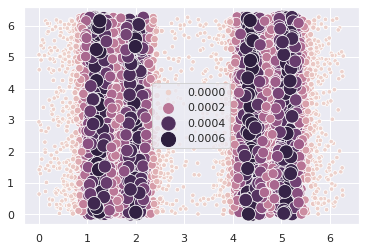

In [20]:
sbs.scatterplot(dist.points[:,0],
                dist.points[:,1],
                size=dist.weights,
                sizes=(20, 200),
                hue=dist.weights)

In [14]:
import pickle

In [18]:
f = open("unitary_results.pkl", "wb")
pickle.dump(results, f)
f.close()

In [35]:
results

[{'risk': [6.93665370342968,
   6.1857933791933055,
   6.250053605650249,
   6.317557812497667,
   6.386381370757507,
   6.454003571564355,
   6.518889699002533,
   6.580550744824178,
   6.282222553351594,
   6.329867650415871,
   6.163545931971126,
   6.065584029071673,
   6.00477680740397,
   6.675962641372777,
   6.176266020508499,
   6.018988140768036,
   6.057530499492159,
   6.1085848647755725,
   6.009080171159623,
   5.940780029135617,
   5.898500658411744,
   5.602934701506378,
   5.598172317622407,
   5.595851559657719,
   5.595613307537107,
   5.594460333252537,
   5.59114153937929,
   5.594527394090926,
   5.453350001004356,
   5.438766178442522],
  'mean': [array([-2.66397590e-04,  3.68628739e-18]),
   array([-1.84594468e-02, -1.08516144e-16]),
   array([-2.19811200e-02, -1.19814187e-16]),
   array([-2.62212991e-02, -1.00499824e-16]),
   array([-2.42287103e-02, -9.66752584e-17]),
   array([-2.55701626e-02, -9.88546742e-17]),
   array([-5.76494036e-03, -1.23845322e-16]),
  

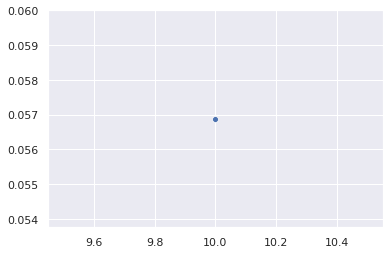

In [32]:
sbs.scatterplot([len(res['circuit']) for res in results], 
                [1 - (max(res['counts'][-1]['1'], res['counts'][-1]['0']) / 4096) for res in results])